In [1]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import xarray as xr
from stompy import xr_transect as xrt
import os
from stompy import utils
import stompy.plot.cmap as scmap
import numpy as np
%matplotlib notebook

In [7]:
import six
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [2]:
turbo=scmap.load_gradient('turbo.cpt')
hot_cold=scmap.load_gradient('hot_and_cold.cpt')

In [8]:
run_dirs=[#'run_salt_20160520-v104',
          #'run_salt_20160520-v107',
          #'run_salt_20160520-v109',
          #'run_salt_20160520-v110',
          #'run_salt_20160520-v111',
          #'run_salt_20160520-v112', 
          'run_salt_20160520-v113', 
          'run_salt_20160520-v114', 
          'run_salt_20160520-v115', 
          'run_salt_20160520-v116', 
    
    
]

In [9]:
try:
    [h.close() for h in hiss]
except NameError:
    pass
his_fns=[os.path.join(d,'DFM_OUTPUT_flowfm/flowfm_0000_his.nc')
         for d in run_dirs]
hiss=[xr.open_dataset(his_fn) for his_fn in his_fns]
for his,d in zip(hiss,run_dirs):
    his.attrs['run_dir']=d

In [10]:
patt='thalweg_pesc.*'

trans=[dfm.extract_transect_his(his,patt) for his in hiss]

<IPython.core.display.Javascript object>


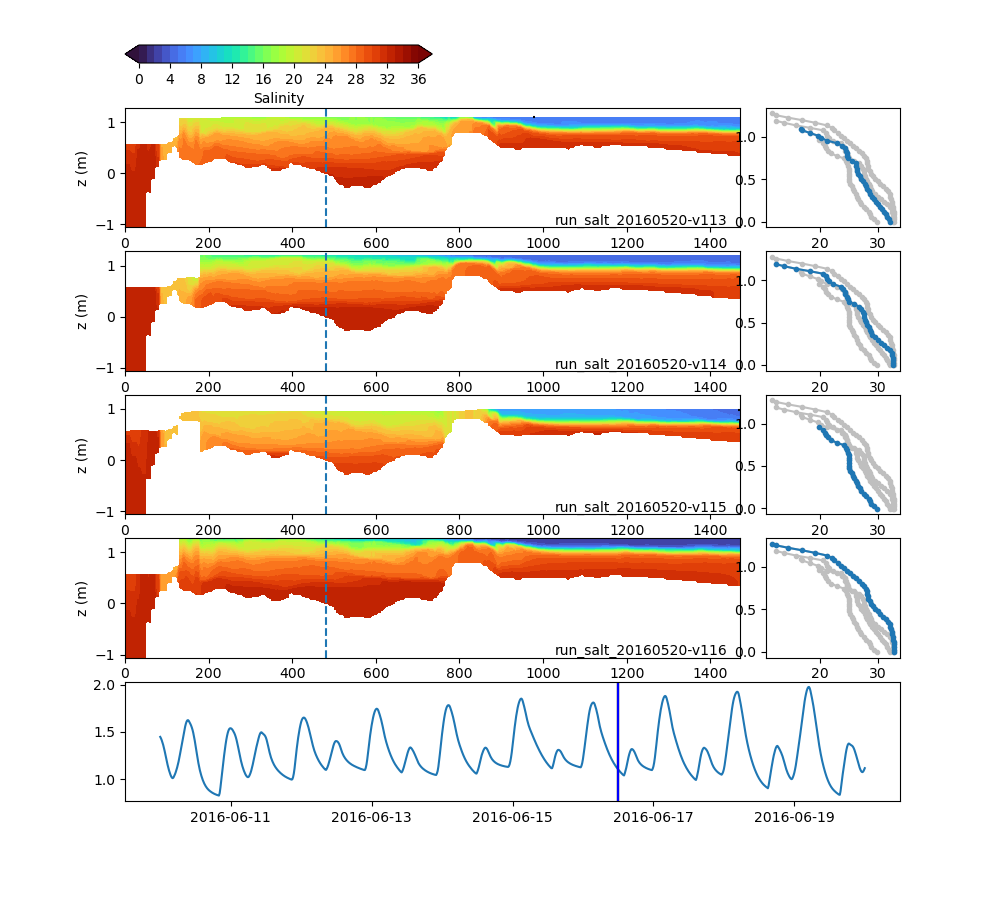

/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  5.544942114773095 32.9876688918032
Range of salinity:  4.367958480632834 32.99926363567171
Range of salinity:  4.48406547235303 32.982503791375315
Range of salinity:  2.0754127564532263 32.978733067432835


In [13]:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)

    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])
    
t=np.datetime64("2016-06-16T12:00")
#t=np.datetime64("2016-06-13T22:00")
#t=np.datetime64("2016-06-12T22:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)

ttrans=[tran.isel(
        time=min(np.searchsorted(tran.time.values,t),
                 tran.dims['time']-1) )
     for tran in trans]
    

for ax,tran in zip(axs,ttrans):
    xrt.get_d_sample(tran)
    cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
    ax.set_ylabel('z (m)')
    xrt.contour(tran,'salinity',np.r_[33.0],ax=ax,colors='k')
    print("Range of salinity: ",float(tran['salinity'].min()),
          float(tran['salinity'].max()))

plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

sampxy=None
for ax,axv,tran in zip(axs,axvs,ttrans):
    txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
    if sampxy is None:
        samp=np.searchsorted(tran.d_sample.values,dist)
        sampxy=txy[samp]
    else:
        dists=utils.dist(sampxy, txy)
        samp=np.argmin(dists)
    axv.plot(tran['salinity'].isel(sample=samp),
             tran['z_ctr'].isel(sample=samp),
             marker='.')
    ax.axvline(tran.d_sample.values[samp],ls='--')
    ax.text(0.98,0.02,tran.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    # ghosted on other axes:
    for ax_other in axvs:
        if ax_other!=ax:
            ax_other.plot(tran['salinity'].isel(sample=samp),
                          tran['z_ctr'].isel(sample=samp),
                          color='0.75',marker='.',zorder=-1)
            

axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

for tran in ttrans:
    axt.axvline( tran.time.values,color='k')
    
axt.axvline(t,color='b')